In [145]:
#Imports
from osgeo import gdal, osr
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import re

## Functions

In [146]:
def convert_rcp(filepath: str) -> dict:
    # Regular expression pattern to extract the RPC values
    pattern = r'(-?\d+(?:\.\d+)?)'

    # Read the RPC values from the text file
    with open(filepath, 'r') as file:
        rpc_values = file.read()

    # Extract the RPC values using the regular expression
    values = [str(x) for x in re.findall(pattern, rpc_values)]

    # Create a dictionary with the keys and values
    rpc_dict = {
        'LINE_OFF': values[0],
        'SAMP_OFF': values[1],
        'LAT_OFF': values[2],
        'LONG_OFF': values[3],
        'HEIGHT_OFF': values[4],
        'LINE_SCALE': values[5],
        'SAMP_SCALE': values[6],
        'LAT_SCALE': values[7],
        'LONG_SCALE': values[8],
        'HEIGHT_SCALE': values[9],
        'LINE_NUM_COEFF': ' '.join(values[10:30]),
        'LINE_DEN_COEFF': ' '.join(values[30:50]),
        'SAMP_NUM_COEFF': ' '.join(values[50:70]),
        'SAMP_DEN_COEFF': ' '.join(values[70:90]),
    	'MIN_LONG': values[91],
        'MIN_LAT': values[92],
        'MAX_LONG': values[93],
        'MAX_LAT': values[94],
        'sampleOFFSET': values[95],
        #'lineOFFSET': values[96],
    }
    return rpc_dict

In [147]:
#CANT use this due to missing stereo_calibration_matrix
def generate_dem(cv_image1, cv_image2, output:str):
    # Set up the stereo block matching algorithm
    bm = cv2.StereoBM_create()

    # Compute the disparity map
    disparity = bm.compute(cv_image1, cv_image2)

    # Convert the disparity map to a 3D point cloud
    points_3d = cv2.reprojectImageTo3D(disparity, stereo_calibration_matrix)

    # Save the point cloud to a file
    np.save(output, points_3d)

In [148]:
def warp_image(image_ds, rpc, output):
    # Create a georeferenced version of the image using the RPCs
    driver = gdal.GetDriverByName('GTiff')
    georef_ds = driver.Create(f'{PATH_TO_TEMP}georef.tif', image_ds.RasterXSize, image_ds.RasterYSize, image_ds.RasterCount, gdal.GDT_Byte)
    georef_ds.SetMetadata(rpc, 'RPC')
    georef_ds.GetRasterBand(1).WriteArray(image_ds.GetRasterBand(1).ReadAsArray())
    #print(georef_ds.GetMetadata('RPC'))
    image_ds = None
    georef_ds = None

    # Reproject the images to the same projection (EPSG:3857 in this case)
    # EPSG:4326, EPSG:7789 also not working
    gdal.Warp(output, f'{PATH_TO_TEMP}georef.tif')
    os.remove(f'{PATH_TO_TEMP}georef.tif')

In [149]:
def stitch_images(cv_image1, cv_image2, outputpath:str):
    # Create the stitcher object
    stitcher = cv2.Stitcher.create()

    # Stitch the images together
    status, stitched_image = stitcher.stitch((cv_image1, cv_image2))

    # Check if the stitching was successful
    if status == cv2.Stitcher_OK:
        # Save the stitched image
        cv2.imwrite(outputpath, stitched_image)
        return stitched_image
    else:
        print(f'Stitching failed! with error {status}')
        return -1
    

In [150]:
def get_disparity_map(cv_image1, cv_image2, roi:list=None) -> np.ndarray:    
    if cv_image1.shape != cv_image2.shape:
        #pad the smaller image
        if cv_image1.shape[0] < cv_image2.shape[0]:
            cv_image1 = np.pad(cv_image1, ((0, cv_image2.shape[0]-cv_image1.shape[0]), (0, 0), (0, 0)), 'constant')
        else:
            cv_image2 = np.pad(cv_image2, ((0, cv_image1.shape[0]-cv_image2.shape[0]), (0, 0), (0, 0)), 'constant')
        if cv_image1.shape[1] < cv_image2.shape[1]:
            cv_image1 = np.pad(cv_image1, ((0, 0), (0, cv_image2.shape[1]-cv_image1.shape[1]), (0, 0)), 'constant')
        else:
            cv_image2 = np.pad(cv_image2, ((0, 0), (0, cv_image1.shape[1]-cv_image2.shape[1]), (0, 0)), 'constant')
            
    if roi is not None:
        # Crop the images to the same size
        cv_image1 = cv_image1[roi[0]:roi[1], roi[2]:roi[3]]
        cv_image2 = cv_image2[roi[0]:roi[1], roi[2]:roi[3]]

    # Convert the images to grayscale
    gray_1 = cv2.cvtColor(cv_image1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(cv_image2, cv2.COLOR_BGR2GRAY)



    # Set up the block matching algorithm
    bm = cv2.StereoBM_create()

    #print(image_1.shape, image_2.shape)

    # Compute the disparity map
    return bm.compute(gray_1, gray_2)

In [151]:
def plot_3d_reconstruction(disparity:np.ndarray, rpc_1:dict, rpc_2:dict) -> None:    
    focal_length = 13.5*(10**(-3)) # Focal length in meters found by chatGPT

    # Compute the baseline using the RPCs
    baseline = np.abs(float(rpc_1['LINE_OFF']) - float(rpc_2['LINE_OFF']))
    depth = focal_length * baseline / disparity

    x, y = np.meshgrid(np.arange(3001),np.arange(3001))
    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(8,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x, y, depth)

    # Show the plot
    plt.show()

In [152]:
def crop_images(image1_path:str, image2_path:str):

    # Open the first image
    ds1 = gdal.Open(image1_path)

    # Read the georeferencing information
    geotransform = ds1.GetGeoTransform()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds1.GetProjection())

    # Get the size of the image in pixels
    x_size, y_size = ds1.GetRasterBand(1).GetBlockSize()

    # Calculate the extent of the image in the original projection
    min_x = abs(geotransform[0])
    max_x = abs(geotransform[0]) + abs(x_size * geotransform[1])
    min_y = abs(geotransform[3]) + abs(y_size * geotransform[5])
    max_y = abs(geotransform[3])
    extent_1 = (min_x, max_x, min_y, max_y)

    # Open the second image
    ds2 = gdal.Open(image2_path)

    # Read the georeferencing information
    geotransform = ds2.GetGeoTransform()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds2.GetProjection())

    # Get the size of the image in pixels
    x_size, y_size = ds2.GetRasterBand(1).GetBlockSize()

    # Calculate the extent of the image in the original projection
    min_x = abs(geotransform[0])
    max_x = abs(geotransform[0]) + abs(x_size * geotransform[1])
    min_y = abs(geotransform[3]) + abs(y_size * geotransform[5])
    max_y = abs(geotransform[3])
    extent_2 = (min_x, max_x, min_y, max_y)

    # Calculate the intersection of the two extents
    min_x = max(extent_1[0], extent_2[0])
    max_x = min(extent_1[1], extent_2[1])
    min_y = max(extent_1[2], extent_2[2])
    max_y = min(extent_1[3], extent_2[3])

    # Crop the images to the intersection extent
    ds1_cropped = gdal.Translate('image_1_cropped.tif', ds1, projWin=[min_x, max_y, max_x, min_y])
    ds2_cropped = gdal.Translate('image_2_cropped.tif', ds2, projWin=[min_x, max_y, max_x, min_y])
    return ds1_cropped, ds2_cropped

In [153]:
def write_rpc_into_geotiff(image_ds_name, rpc_name) -> None:
    image_ds = gdal.Open(image_ds_name)
    rpc = convert_rcp(rpc_name)

    driver = gdal.GetDriverByName('GTiff')
    georef_ds = driver.Create(image_ds_name, image_ds.RasterXSize, image_ds.RasterYSize, image_ds.RasterCount, gdal.GDT_Byte)
    georef_ds.SetMetadata(rpc, 'RPC')
    georef_ds.GetRasterBand(1).WriteArray(image_ds.GetRasterBand(1).ReadAsArray())
    image_ds = None
    georef_ds = None

In [154]:
def calculate_3d_points (disparity:np.ndarray,ds_georef) -> np.ndarray:
    
    num_rows, num_cols = disparity.shape

    points_3d = np.empty((num_rows, num_cols, 3))
    for i in range(num_rows):
        for j in range(num_cols):
            points_3d[i,j,0] = ds_georef.GetGeoTransform()[0] + j*ds_georef.GetGeoTransform()[1] + i*ds_georef.GetGeoTransform()[2]
            points_3d[i,j,1] = ds_georef.GetGeoTransform()[3] + j*ds_georef.GetGeoTransform()[4] + i*ds_georef.GetGeoTransform()[5]
            points_3d[i,j,2] = disparity[i,j]
    return points_3d

In [155]:
def plot_3d(points):
    # Extract the x, y, and z coordinates of the points
    x = points[:, :, 0]
    y = points[:, :, 1]
    z = points[:, :, 2]

    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(8,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x[::2], y[::2], z[::2],linewidths=0.1, alpha=0.5, s=0.1)

    # Show the plot
    plt.show()

In [156]:
def plot_3d_filtered(points):
    # Extract the x, y, and z coordinates of the points
    x = points[:, :, 0]
    y = points[:, :, 1]
    z = points[:, :, 2]

    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(8,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x[z>=10], y[z>=10], z[z>=10],linewidths=0.1, alpha=0.5, s=1)

    # Show the plot
    plt.show()

In [157]:
def allign_coords(image_coords1, image_coords2):
    from scipy.optimize import minimize
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Assume we have two sets of 3D image coordinates, called 'image_coords1' and 'image_coords2'
    
    # Define an objective function that calculates the alignment error
    def alignment_error(params, points1, points2):
        rotation_matrix = np.array([
            [np.cos(params[2]), -np.sin(params[2]), 0],
            [np.sin(params[2]), np.cos(params[2]), 0],
            [0, 0, 1]
        ])
        translation_vector = np.array([params[0], params[1], 0])
        transformed_points = np.dot(points2, rotation_matrix.T) + translation_vector
        return np.sum((points1 - transformed_points) ** 2)
    
    # Initialize the optimization
    x0 = [0, 0, 0]
    result = minimize(alignment_error, x0, args=(image_coords1, image_coords2))
    params = result.x
    
    # Apply the optimal transformation to the second point cloud
    rotation_matrix = np.array([
        [np.cos(params[2]), -np.sin(params[2]), 0],
        [np.sin(params[2]), np.cos(params[2]), 0],
        [0, 0, 1]
    ])
    translation_vector = np.array([params[0], params[1], 0])
    image_coords2_aligned = np.dot(image_coords2, rotation_matrix.T) + translation_vector
    
    # Remove outliers by ignoring points with large distances
    distances = np.sum((image_coords1 - image_coords2_aligned) ** 2, axis=1,keepdims=True)
    outlier_mask = distances < np.percentile(distances, 90) # keep 98% of the data
    print(outlier_mask[:,0,:].shape)
    #TODO: FILTER OUTLIER
    image_coords1_filtered = image_coords1
    image_coords2_aligned_filtered = image_coords2_aligned
    
    # Plot the aligned point cloud, ignoring the outliers
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(image_coords1_filtered[:, 0], image_coords1_filtered[:, 1], image_coords1_filtered[:, 2], c='r', marker='o')
    ax.scatter(image_coords2_aligned_filtered[:, 0], image_coords2_aligned_filtered[:, 1], image_coords2_aligned_filtered[:, 2], c='b', marker='o')
    ax.set_xlim3d(0, 20000)
    ax.set_ylim3d(0, 20000)
    plt.show()

In [158]:
def get_min_max_long_lat_of_image(image_path):
    # Assume we have a set of 3D image coordinates, called 'image_coords'
    # Define a function that converts 3D image coordinates to longitudes and latitudes
    ds = gdal.Open(image_path)
    width = ds.RasterXSize
    height = ds.RasterYSize
    gt = ds.GetGeoTransform()
    print(gt)
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3] 
    return minx, maxx, miny, maxy

## Main Function

In [159]:
#MAIN
# defines
PATH_TO_IMAGES = '/root/PLUS-IBBC/testimgs/'
PATH_TO_TEMP = '/root/PLUS-IBBC/temp/'
IMAGES = ['01.tif','02.tif','03.tif','04.tif','05.tif', '06.tif','07.tif']
# Open the images as datasets
image_1_ds = gdal.Open(f'{PATH_TO_IMAGES}{IMAGES[0]}')
image_2_ds = gdal.Open(f'{PATH_TO_IMAGES}{IMAGES[1]}')

# Get the RPCs for the images
rpc_1 = convert_rcp(f'{PATH_TO_IMAGES}rpc_{IMAGES[0][:-4]}.txt')
rpc_2 = convert_rcp(f'{PATH_TO_IMAGES}rpc_{IMAGES[1][:-4]}.txt')




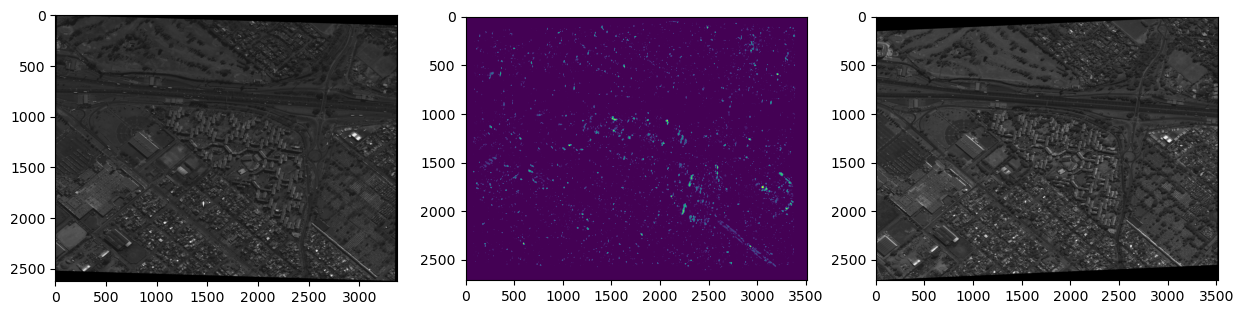

In [160]:
# Warp images to ground coordinates
REPROJECTED_IMAGES = ['image1_reprojected.tif', 'image2_reprojected.tif']
warp_image(image_1_ds,rpc_1,f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
warp_image(image_2_ds,rpc_2,f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}')

# create disparity map out of 2 geo-referenced images
image_1 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
image_2 = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}')
disparity = get_disparity_map(image_1, image_2)

# Plot the disparity map and left image
fig = plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(image_1)
plt.subplot(132)
plt.imshow(disparity)
plt.subplot(133)
plt.imshow(image_2)
plt.show()

In [161]:
warp_image = gdal.Open(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
points = calculate_3d_points(disparity, warp_image)


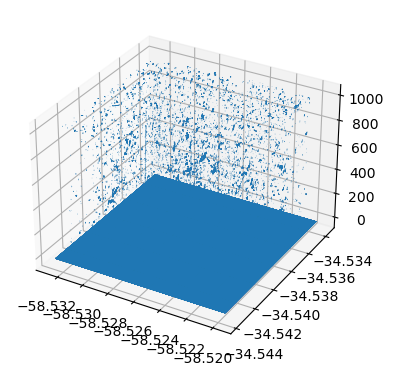

In [162]:
plot_3d(points)


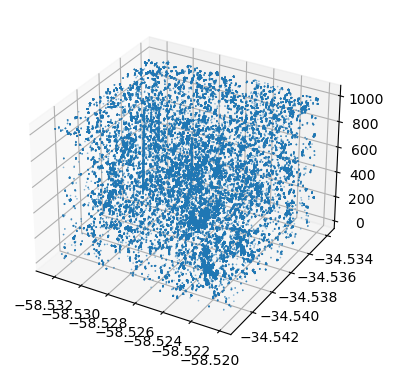

In [163]:
plot_3d_filtered(points)

In [170]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt

# compute point cloud:
pcd = np.empty((disparity.shape[0], disparity.shape[1], 3))
height, width = disparity.shape
for i in range(height):
   for j in range(width):
       z = disparity[i][j]/disparity.max()
       x = j
       y = i
       pcd[i,j,0] = x
       pcd[i,j,1] = y
       pcd[i,j,2] = z

# plot point cloud:
plot_3d_filtered(pcd)




In [ ]:
image_1_reprojected = gdal.Open(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
print(image_1_reprojected.GetGeoTransform())

# point cloud from disparity map and georeferenced images

(-58.53276823432684, 3.7376539189432632e-06, 0.0, -34.53369260814569, 0.0, -3.7376539189432632e-06)


In [ ]:
#construct 3D point cloud from disparity map
image_1_coords = get_3d_coords(disparity, image_1, rpc_1)
image_2_coords = get_3d_coords(disparity, image_2, rpc_2)

NameError: name 'get_3d_coords' is not defined

In [ ]:
# Stitch images
stitched_image = stitch_images(image_1,image_2,f'{PATH_TO_TEMP}stitched_image.tif')
if stitched_image != -1:
    # Plot the stitched image
    plt.imshow(stitched_image)
    plt.show()


Stitching failed! with error 1


In [ ]:
# Clear tmp folder
for file in os.listdir(PATH_TO_TEMP):
    os.remove(f'{PATH_TO_TEMP}{file}')

In [ ]:
#3D reconstruction
#TODO: Check why division by zero error in disparity
print(get_min_max_long_lat_of_image('temp/image2_reprojected.tif'))
#plot_3d_reconstruction(disparity, rpc_1, rpc_2)
#points_left, points_right = calculate_3d_points(disparity, rpc_1, rpc_2)
#plot_3d(points_left)
#plot_3d(points_right)

(-58.48579997758683, 3.834783330242905e-06, 0.0, -34.485245113773985, 0.0, -3.834783330242905e-06)
(-58.48579997758683, -58.47232071418102, -34.49562203746562, -34.485245113773985)


In [ ]:
# get the longitude and latitude out of RPCs



(3001, 3)


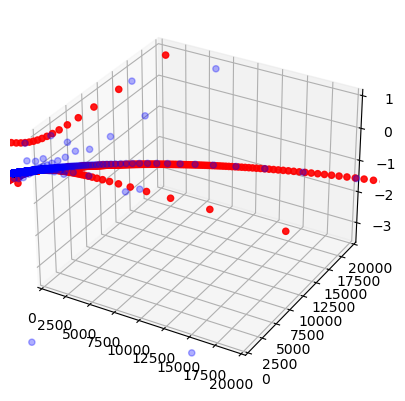

In [ ]:
allign_coords(points_left, points_right)

In [ ]:
# triangulate using image1 and image2


In [ ]:
#TODO: CHECK IF WE STILL NEED DIS?
# Estimate the relative depths of the pixels using the RPCs
image_1_ds = gdal.Open('img_01.tif')
image_2_ds = gdal.Open('img_02.tif')

rpc_1 = image_1_ds.GetMetadata('RPC')
rpc_2 = image_2_ds.GetMetadata('RPC')
#rpc_1 = convert_rcp('/root/PLUS-IBBC/rpc_05.txt')
#rpc_2 = convert_rcp('/root/PLUS-IBBC/rpc_06.txt')



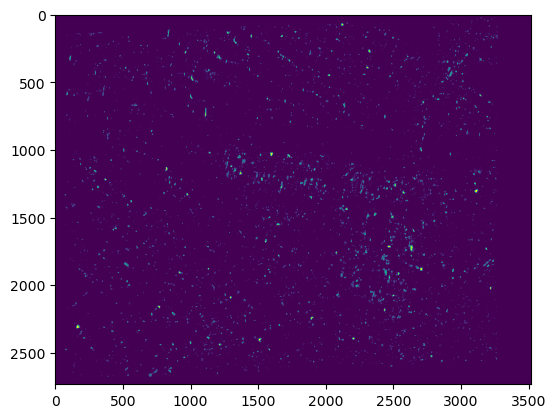

## HELP STUFF:
This stuff is to figure out what actually is in an image, and to modify the images

In [ ]:
# Open the image
image_ds = gdal.Open('temp/image2_reprojected.tif')
#image_test = gdal.Open('01.tif')

# Get the RPCs for the image
rpc = image_ds.GetMetadata('RPC')
print(image_ds.GetMetadataDomainList())
#print(image_test.GetMetadataDomainList())
print(image_ds.GetMetadata('DERIVED_SUBDATASETS'))
#print(image_test.GetMetadata('RPC'))

['IMAGE_STRUCTURE', 'DERIVED_SUBDATASETS', '']
{'DERIVED_SUBDATASET_1_NAME': 'DERIVED_SUBDATASET:LOGAMPLITUDE:temp/image2_reprojected.tif', 'DERIVED_SUBDATASET_1_DESC': 'log10 of amplitude of input bands from temp/image2_reprojected.tif'}


In [ ]:
# Write RPCs into image
images = ['testimgs/07.tif']
rpcs = ['testimgs/rpc_07.txt']

for image_ds_name, rpc_name in zip(images, rpcs):
    write_rpc_into_geotiff(image_ds_name, rpc_name)